# Content

**Warning: <span style="color:red">high execution time (several hours) </span>**

Code below computes the model performance measures for the following input features:

    - Character Bi-grams
    - Character Tri-grams
    - Character 4-grams
    - Character 5-grams
    - Character 6-grams
    - Character 7-grams
    - Character 8-grams
    - Word Uni-gram
    - Word Bi-grams
    - Word Tri-grams

Code uses **Random Forest** and **Gradient Boosting** computed after *grid-search.*

In [61]:
# Import base libraries for mathematical operations, dataframes, time and plotting
import numpy as np
import pandas as pd
from time import time
import re

import matplotlib.pyplot as plt

font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore")



from helper import preprocessor as pp
from helper import precisionmeasures as pm


In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as prfs

In [4]:
# Code Starting time
t0 = time()

## 1. Data upload

In [5]:
class_names = ['Hate','Offensive','Neutral']

In [6]:
# upload the dataset
data = pp.load_data('labeled_data.csv')
max_length = 140
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
# drop any rows with null (after preprocessing)
data = data.dropna()
# print first 5 rows of the data set
data.head()

,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [7]:
# Split the dataset into training and test sets (2:1)
#X_train, X_test, Y_train, Y_test = train_test_split(data.clean_tweet, data.labels, test_size=0.33, random_state=42)

train_data, test_data = data[:20000], data[20000:]
X_train,Y_train = train_data.clean_tweet,train_data.labels
X_test,Y_test = test_data.clean_tweet,test_data.labels

In [8]:
feature_list = ['char bi-gram','char tri-gram', 'char 4-gram',
                'char 5-gram', 'char 6-gram',
                'word uni-gram','word bi-gram','word tri-gram']

In [9]:
def feature_info(feature):
    ''' 
    Input: Feature
    Steps:
        Split each feature at whitespaces and hyphens and convert into lower case
        Set analyzer to 0th element of the split list 'char'/'word'
        Convert 1st element into numerical value
        Convert words like uni-1, bi-2, tri-3
    Output: analyzer = word/char
            N = range of N-grams
    '''
    token = re.split(r'\s|-', feature)
    analyzer = token[0]
    
    temp_dict = {'uni':1, 'bi': 2, 'tri': 3}
    
    if token[1] in temp_dict:
        N = temp_dict[token[1]]
    else:
        N = np.int(token[1])
    return (analyzer, N)

In [10]:
def performance_metrics_table(test,pred,feature):
    '''Inputs:
            test = actual labels of test set
            pred = model predictions for the the test set
            feature = feature name
            
            Computes macro- and micro- precision, recall and F1-score
        Output:
            Multi-index data frame with 3 precision measures 
    '''
    temp_dict = {'Performance':['Precision','Recall','F1-Score']}
    averages = ['micro','macro']
    for average in averages:
        p,r,f,_ = prfs(test,pred,average = average)
        temp_dict[average]= np.round((p,r,f),4)
    temp_df = pd.DataFrame(temp_dict)
    temp_df = pd.melt(temp_df, id_vars=['Performance'], value_vars=averages,
                        var_name='Metric', value_name=feature).set_index(['Metric','Performance'])
    temp_df = temp_df.rename_axis([None,'Performance Measures'])
    return temp_df

In [11]:
# For Each feature fit the decision tree models.
for i,feature in enumerate(feature_list):  
    # Extract infro from each feature  
    analyzer,N_range = feature_info(feature)
    # Vectorize the text data
    vectorizer = TfidfVectorizer(analyzer = analyzer,ngram_range = (N_range,N_range))
    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)
    #########################################
    # Initiate Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=500, max_depth = 100)
    
    print('=='*30)
    ta = time()
    rf_clf.fit(x_train, Y_train)
    y_pred_rf = rf_clf.predict(x_test)
    tb = time()-ta
    print('Total Time for Random Forest fit on {} is {} sec'.format(feature.lower(), np.round(tb)))
    #########################################
    # Store the results from individual classifier per 
    if i==0:
        # Tables for storing performance metrics
        rf_tbl = performance_metrics_table(Y_test,y_pred_rf,feature)
    else:
        # Join together tables for new features
        rf_tbl = rf_tbl.join(performance_metrics_table(Y_test,y_pred_rf,feature))
        

print('=='*30)

Total Time for Random Forest fit on char bi-gram is 113.0 sec
Total Time for Random Forest fit on char tri-gram is 87.0 sec
Total Time for Random Forest fit on char 4-gram is 83.0 sec
Total Time for Random Forest fit on char 5-gram is 97.0 sec
Total Time for Random Forest fit on char 6-gram is 110.0 sec
Total Time for Random Forest fit on word uni-gram is 34.0 sec
Total Time for Random Forest fit on word bi-gram is 15.0 sec
Total Time for Random Forest fit on word tri-gram is 9.0 sec


In [12]:
#print performance metric table for Random Forests for the feature list
print('=='*22,'Random Forest Classifier','=='*22)
rf_tbl

============================================ Random Forest Classifier ============================================


char bi-gram  char tri-gram  char 4-gram  \
      Performance Measures                                             
micro Precision                   0.8825         0.9078       0.8990   
      Recall                      0.8825         0.9078       0.8990   
      F1-Score                    0.8825         0.9078       0.8990   
macro Precision                   0.7939         0.7930       0.7795   
      Recall                      0.5588         0.6191       0.5947   
      F1-Score                    0.5816         0.6313       0.6110   

                            char 5-gram  char 6-gram  word uni-gram  \
      Performance Measures                                            
micro Precision                  0.8861       0.8497         0.8810   
      Recall                     0.8861       0.8497         0.8810   
      F1-Score                   0.8861       0.8497         0.8810   
macro Precision                  0.7634       0.7146         0.8130   
      Recall                     0.5572       0.4681         0.5340   
      F1-Score                   0.5796       0.4963         0.5565   

                            word bi-gram  word tri-gram  
      Performance Measures                               
micro Precision                   0.7951         0.7947  
      Recall                      0.7951         0.7947  
      F1-Score                    0.7951         0.7947  
macro Precision                   0.5983         0.2649  
      Recall                      0.3342         0.3333  
      F1-Score                    0.2970         0.2952

In [13]:
t1 = time()
code_time = t1 - t0
print("=="*30)
print('Total Code Execution Time: {} seconds'. format(np.round(code_time),4))
print("=="*30)

Total Code Execution Time: 556.0 seconds


In [49]:
# create new table for plotting
tbl = rf_tbl.reset_index()

,level_0,Performance Measures,char bi-gram,char tri-gram,char 4-gram,char 5-gram,char 6-gram,word uni-gram,word bi-gram,word tri-gram
0,micro,Precision,0.8825,0.9078,0.8990,0.8861,0.8497,0.8810,0.7951,0.7947
1,micro,Recall,0.8825,0.9078,0.8990,0.8861,0.8497,0.8810,0.7951,0.7947
2,micro,F1-Score,0.8825,0.9078,0.8990,0.8861,0.8497,0.8810,0.7951,0.7947
3,macro,Precision,0.7939,0.7930,0.7795,0.7634,0.7146,0.8130,0.5983,0.2649
4,macro,Recall,0.5588,0.6191,0.5947,0.5572,0.4681,0.5340,0.3342,0.3333
5,macro,F1-Score,0.5816,0.6313,0.6110,0.5796,0.4963,0.5565,0.2970,0.2952


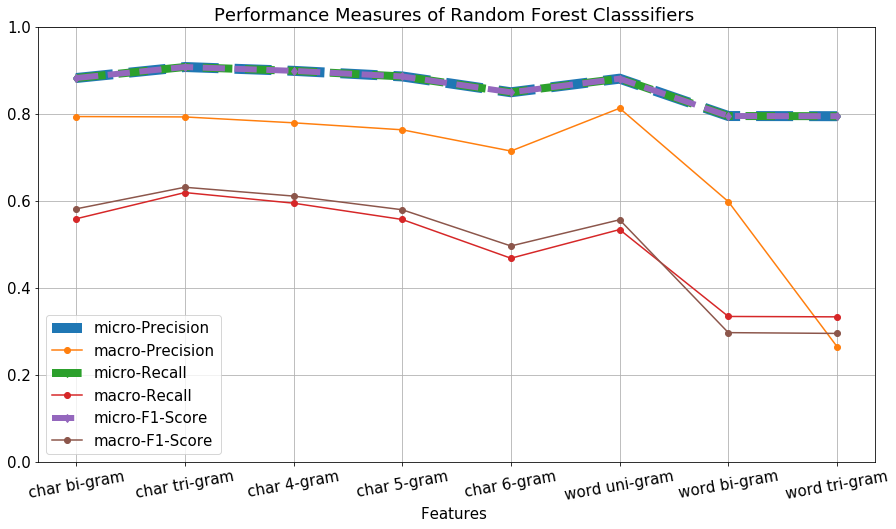

In [69]:
plt.figure(figsize = (15,8))
for i in range(3):
    plt.plot(np.arange(8),tbl.iloc[i,2:],marker = 'd',
             linestyle = '--',linewidth = 10-2*i,
             label = np.str(tbl.iloc[i,0])+'-'+np.str(tbl.iloc[i,1]))
    plt.plot(np.arange(8),tbl.iloc[i+3,2:],marker = 'o',
            label = np.str(tbl.iloc[i+3,0])+'-'+np.str(tbl.iloc[i+3,1]))
plt.legend()
plt.title('Performance Measures of Random Forest Classsifiers ')
plt.xlabel('Features ')
plt.xticks(np.arange(8),rf_tbl.columns, rotation = 10);
plt.ylim([0,1])
plt.grid()